## Experimento 1. 
## Predicción de permanencia de migrantes mexicanos en situación irregular en Estados Unidos

Selección y limpieza de datos a partir de las tablas <b>MIG</b> y <b>MIGOTHER</b>.

La tabla <b>MIG</b> contiene información a nivel personal y detalles sobre todos los cruces indocumentados (hasta 30) de cada jefe de familia, así como toda la actividad económica y social durante el último viaje migratorio a los Estados Unidos.

La tabla <b>MIGOTHER</b> contiene la misma información pero considera otra persona del hogar que emigró a los Estados Unidos en aquellos hogares donde el jefe del hogar no tuvo experiencia migratoria.

El dataset se forma a partir de la combinación de ambas tablas considerando aquellas columnas que comparten. (Ver documentación para detalles)

Para este experimento se considera solamente información pertinente al último viaje migratorio realizado, tomando como etiqueta de clase al campo 'uscurtrp' que responde a la pregunta ¿Actualmente se está en último viaje migratorio?.

Así, la etiqueta de clase puede tomar dos valores posibles:<br>
>1: Sí (No ha regresado)<br>2: No (Ya regresó)<br>

Para todos los clasificadores utilizados, se tomará la clase 1 (No ha regresado) como clase **Positive**.

<br>

---

In [1]:
#Definición de clases Positive y Negative
#Formato: (clase, label)
    #clase: valor numérico
    #label: valor de texto (etiqueta)
#¿Actualmente se está en último viaje migratorio?
pos_class = (1, 'Sí') #Clase positive (Sí)
neg_class = (0, 'No') #Clase negative  (No)

# Tareas previas
Añadir librerías, cargar dataset, generar dfs. calcular IR e imputar datos.

### Añadir librerías necesarias

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tabulate import tabulate
from scipy.spatial.distance import mahalanobis

sys.path.append(os.path.abspath(os.path.join('..'))) #Utils path
from tesis_experiments_utils import classifiers_utils as cu
from tesis_experiments_utils import confusion_matrices_utils as cmu
from tesis_experiments_utils import data_utils as du
from tesis_experiments_utils import files_utils as fu
from tesis_experiments_utils import learning_curves_utils as lcu

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### Cargar el dataset en un dataframe y generar los df con los datos y etiquetas

Variables para la lectura del dataset

Crear carpetas para almacenamiento de los resultados, particiones de datos, etc.

In [3]:
fu.setup_folders()

La carpeta 'particiones/hold_out' ya existe
La carpeta 'datos_imputados' ya existe
La carpeta 'matrices_de_confusion' ya existe
La carpeta 'curvas_de_aprendizaje' ya existe
La carpeta 'resultados' ya existe


In [4]:
#Ubicación del dataset
path_to_data = os.path.join('..', 'datasets')
path_to_file = os.path.join(path_to_data,'regreso_ultimo_viaje', 'regreso_ultimo_viaje.csv')

#Atributos categóricos del dataset
cat_atts = ['sex', 'statebrn', 'placebrn', 'marstat', 'edyrs', 'occ', 'usyrl', 'usdocl', 'usstatel', 'usplacel', 'usoccl', 'usbyl', 'reltrip', 'paistrip', 'sport', 'social', 'chicanos',
            'blacks', 'anglos', 'latinos', 'lodging', 'english', 'finhelp', 'bankacct', 'remit1', 'remit2', 'remit3', 'remit4', 'remit5', 'savings1', 'savings2', 'savings3', 'savings4',
            'savings5', 'schools', 'unemp', 'foodst', 'welfare', 'doctor', 'hospital']


## Métodos de validación
Definición de variables y métodos necesarios para los métodos de validación Hold-out y k-fold-cross-validation

Realizar partición de datos con Hold-out

In [5]:
X_train, X_test, y_train, y_test = du.stratified_hold_out(path_to_file, cat_atts, test_size=0.2)
X = pd.concat([X_train, X_test])

Partición de datos hold out 0.80-0.20 encontrada en 'particiones/hold_out'
Partición de datos cargada exitosamente desde el directorio 'particiones/hold_out/0.80_0.20'


Codificación de etiquetas de clase:

    1: Sí (no ha regresado), originalmente 1
    0: No (regresó), originalmente 2

In [6]:
y_train = np.array([0 if i == 2 else 1 for i in y_train])
y_test = np.array([0 if i == 2 else 1 for i in y_test])

### K-fold Cross Validation

In [7]:
kf_cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

### Cálculo de Imbalance Ratio

In [8]:
y = np.concatenate((y_train, y_test))

card_class1 = sum(1 for l in y if l == pos_class[0]) #Cardinalidad de la clase 1
card_class2 = sum(1 for l in y if l == neg_class[0]) #Cardinalidad de la clase 2

IR = max(card_class1,card_class2)/min(card_class1,card_class2)

print("Instancias en el dataset: %i" % len(y))
print("Cadinalidad de la clase 1: %i" % card_class1)
print("Cadinalidad de la clase 2: %i" % card_class2)


if(IR <= 1.5):
  print("Dataset balanceado con IR = %.4f" % IR)
else:
  print("Dataset desbalanceado con IR = %.4f" % IR)


Instancias en el dataset: 9617
Cadinalidad de la clase 1: 2549
Cadinalidad de la clase 2: 7068
Dataset desbalanceado con IR = 2.7729


## Imputación de datos perdidos

In [9]:
X_train, X_test = du.impute_data(X_train, X_test, cat_atts,'median')

Datos imputados con estrategia 'median' encontrados en 'datos_imputados'
Datos imputados cargados exitosamente desde 'datos_imputados'


## Normalización del dataset para utilizarlo con clasificadores basádos en métricas

Normalización de los atributos del dataset utilizando la forma:

$
    \Large z = \frac{(x-\mu)}{\sigma}
$

También conocida como z-score

In [10]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out()) # type: ignore
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out()) # type: ignore

## One hot encoding sobre atributos categóricos para utilizarlo con clasificadores basados en reglas

In [11]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#pd.concat(atributos no categóricos, atributos categóricos codificados, nombre de columnas, axis)
X_train_encoded = pd.concat([X_train.drop(cat_atts, axis=1), 
                             pd.DataFrame(encoder.fit_transform(X_train[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)
X_test_encoded = pd.concat([X_test.drop(cat_atts, axis=1),
                            pd.DataFrame(encoder.transform(X_test[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)

/home/daniel/anaconda3/envs/migration/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 2, 4, 5, 6, 8, 9, 10, 33] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Clasificadores k-NN

Experimentación con la distancia de Mahalanobis

In [12]:
cov_matrix = np.cov(X_train_scaled.T)

def mahalanobis_distance(X, y):
    return mahalanobis(X, y, np.linalg.inv(cov_matrix))

### **Elección del parámetro k**

Elección del parámetro k que minimiza el error de generalización utilizando *10-fold cross validation* a partir del Coeficiente de Correlación de Matthews.

In [13]:
k_range = range(1,52,2)
metrics = [mahalanobis_distance, 'euclidean', 'manhattan', 'chebyshev', 'minkowski']
params = {'n_neighbors': k_range, 'metric': metrics}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
knn = KNeighborsClassifier()

best_knn = GridSearchCV(knn,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', verbose=3)
best_knn.fit(X_train_scaled, y_train)
best_mcc = best_knn.best_score_
best_k = best_knn.best_params_['n_neighbors']
best_metric = best_knn.best_params_['metric']

print(f'Mejor k: {best_k}, mejor métrica: {best_metric}, MCC media: {best_mcc:.4f}.')

Fitting 10 folds for each of 130 candidates, totalling 1300 fits
[CV 5/10] END metric=<function mahalanobis_distance at 0x7cff87f37600>, n_neighbors=3; balanced_accuracy: (test=0.760) matthews_corrcoef: (test=0.548) total time= 5.1min
[CV 5/10] END metric=<function mahalanobis_distance at 0x7b9511f2b600>, n_neighbors=1; balanced_accuracy: (test=0.738) matthews_corrcoef: (test=0.475) total time= 5.2min
[CV 10/10] END metric=<function mahalanobis_distance at 0x71824a127600>, n_neighbors=1; balanced_accuracy: (test=0.736) matthews_corrcoef: (test=0.470) total time= 5.2min
[CV 4/10] END metric=<function mahalanobis_distance at 0x761b4a32b600>, n_neighbors=3; balanced_accuracy: (test=0.756) matthews_corrcoef: (test=0.519) total time= 5.2min
[CV 1/10] END metric=<function mahalanobis_distance at 0x7545f1533600>, n_neighbors=1; balanced_accuracy: (test=0.716) matthews_corrcoef: (test=0.422) total time= 5.2min
[CV 7/10] END metric=<function mahalanobis_distance at 0x75a658b33600>, n_neighbors=

Archivo de curvas de aprendizaje creado en curvas_de_aprendizaje/curvas_de_aprendizaje.csv
Curvas de aprendizaje del clasificador 15-NN almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


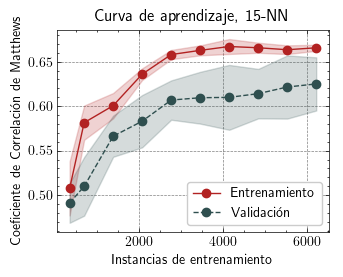

In [14]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
lcu.plot_and_save_learning_curve(knn, f'{best_k}-NN',X_train_scaled, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Archivo de resultados creado en resultados/resultados.csv
Resultados del clasificador 15-NN almacenados en resultados/resultados.csv
Archivo de predicciones creado en resultados/predicciones.csv
Predicciones del clasificador 15-NN almacenadas en resultados/predicciones.csv.
Accuracy: 0.8638
Balanced accuracy: 0.7833
Recall: 0.6118
Specificity: 0.9547
AUC: 0.6118
MCC: 0.6306
Precision: 0.8298
F1-score: 0.7043


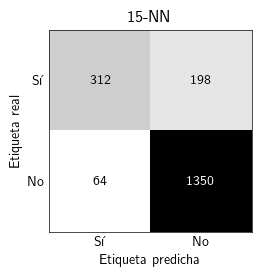

In [15]:
cu.train_and_evaluate_model(knn, X_train_scaled, y_train, X_test_scaled, y_test, f'{best_k}-NN',pos_class,neg_class)

# Naïve Bayes

### **Naïve Bayes**

Curvas de aprendizaje del clasificador Naïve Bayes almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


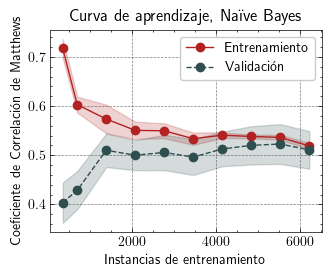

In [16]:
nb = GaussianNB()
lcu.plot_and_save_learning_curve(nb, 'Naïve Bayes',X_train_encoded, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Predicciones del clasificador Naïve Bayes almacenadas en resultados/predicciones.csv.
Accuracy: 0.7469
Balanced accuracy: 0.7927
Recall: 0.8902
Specificity: 0.6952
AUC: 0.8902
MCC: 0.5184
Precision: 0.5130
F1-score: 0.6509


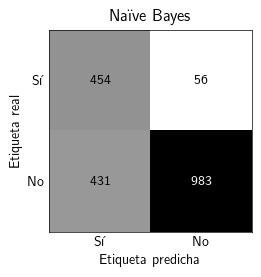

In [17]:
cu.train_and_evaluate_model(nb, X_train_encoded, y_train, X_test_encoded, y_test, 'Naïve Bayes',pos_class,neg_class)

# Decision Tree

In [18]:
depth_range = range(1,52)
params = {'max_depth': depth_range}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
dtree = DecisionTreeClassifier()
best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', verbose=3)
best_tree.fit(X_train_encoded, y_train)
best_mcc = best_tree.best_score_
best_depth = best_tree.best_params_['max_depth']

print(f'Best MCC: {best_mcc}, best depth: {best_depth}')

Fitting 10 folds for each of 51 candidates, totalling 510 fits
[CV 2/10] END max_depth=1; balanced_accuracy: (test=0.759) matthews_corrcoef: (test=0.497) total time=   0.2s
[CV 1/10] END max_depth=1; balanced_accuracy: (test=0.765) matthews_corrcoef: (test=0.511) total time=   0.2s
[CV 3/10] END max_depth=1; balanced_accuracy: (test=0.740) matthews_corrcoef: (test=0.458) total time=   0.2s
[CV 6/10] END max_depth=1; balanced_accuracy: (test=0.731) matthews_corrcoef: (test=0.443) total time=   0.2s
[CV 4/10] END max_depth=1; balanced_accuracy: (test=0.732) matthews_corrcoef: (test=0.435) total time=   0.2s[CV 5/10] END max_depth=1; balanced_accuracy: (test=0.767) matthews_corrcoef: (test=0.506) total time=   0.2s

[CV 8/10] END max_depth=1; balanced_accuracy: (test=0.743) matthews_corrcoef: (test=0.473) total time=   0.2s
[CV 9/10] END max_depth=1; balanced_accuracy: (test=0.779) matthews_corrcoef: (test=0.549) total time=   0.2s
[CV 7/10] END max_depth=1; balanced_accuracy: (test=0.744

In [19]:
min_samples_split_range = range(2,41)
min_samples_leaf_range = range(1,21)
params = {'min_samples_split': min_samples_split_range, 'min_samples_leaf':min_samples_leaf_range}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
dtree = DecisionTreeClassifier(max_depth=best_depth)

best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', return_train_score=False, verbose=3)
best_tree.fit(X_train_encoded, y_train)
best_mcc = best_tree.best_score_
best_min_samples_split = best_tree.best_params_['min_samples_split']
best_min_samples_leaf = best_tree.best_params_['min_samples_leaf']

print(best_min_samples_split, best_min_samples_leaf)

Fitting 10 folds for each of 780 candidates, totalling 7800 fits
[CV 9/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.841) matthews_corrcoef: (test=0.720) total time=   0.4s
[CV 4/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.839) matthews_corrcoef: (test=0.679) total time=   0.4s
[CV 7/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.832) matthews_corrcoef: (test=0.675) total time=   0.4s
[CV 3/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.832) matthews_corrcoef: (test=0.688) total time=   0.5s
[CV 2/10] END min_samples_leaf=1, min_samples_split=3; balanced_accuracy: (test=0.830) matthews_corrcoef: (test=0.671) total time=   0.4s
[CV 2/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.829) matthews_corrcoef: (test=0.662) total time=   0.5s
[CV 5/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.850) matthews_corrcoef: (

In [20]:
best_min_samples_split, best_min_samples_leaf

(18, 6)

Curvas de aprendizaje del clasificador Decision Tree almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


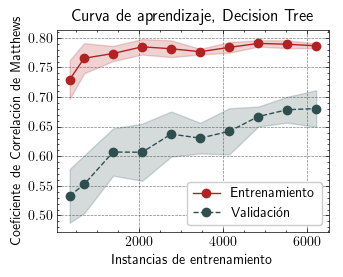

In [21]:
dtree = DecisionTreeClassifier(splitter="best", max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
lcu.plot_and_save_learning_curve(dtree, 'Decision Tree', X_train_encoded, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Predicciones del clasificador Decision Tree almacenadas en resultados/predicciones.csv.
Accuracy: 0.8680
Balanced accuracy: 0.8199
Recall: 0.7176
Specificity: 0.9222
AUC: 0.7176
MCC: 0.6545
Precision: 0.7689
F1-score: 0.7424


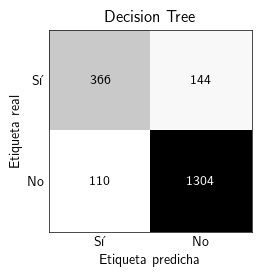

In [22]:
cu.train_and_evaluate_model(dtree, X_train_encoded, y_train, X_test_encoded, y_test, 'Decision Tree',pos_class,neg_class)

# Random Forest

In [23]:
rf = RandomForestClassifier(bootstrap=True, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
n_estimators_range = range(100,1100,100)
params = {'n_estimators': n_estimators_range}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
best_rf = GridSearchCV(rf,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', verbose=3)
best_rf.fit(X_train_encoded, y_train) 
best_mcc = best_tree.best_score_
best_n_estimators = best_rf.best_params_['n_estimators']

print(f'Best MCC: {best_mcc}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 3/10] END n_estimators=100; balanced_accuracy: (test=0.726) matthews_corrcoef: (test=0.585) total time=   1.2s
[CV 7/10] END n_estimators=100; balanced_accuracy: (test=0.696) matthews_corrcoef: (test=0.537) total time=   1.3s
[CV 5/10] END n_estimators=100; balanced_accuracy: (test=0.713) matthews_corrcoef: (test=0.582) total time=   1.3s
[CV 8/10] END n_estimators=100; balanced_accuracy: (test=0.701) matthews_corrcoef: (test=0.551) total time=   1.3s
[CV 4/10] END n_estimators=100; balanced_accuracy: (test=0.709) matthews_corrcoef: (test=0.549) total time=   1.4s
[CV 9/10] END n_estimators=100; balanced_accuracy: (test=0.693) matthews_corrcoef: (test=0.545) total time=   1.4s
[CV 10/10] END n_estimators=100; balanced_accuracy: (test=0.729) matthews_corrcoef: (test=0.584) total time=   1.4s
[CV 1/10] END n_estimators=100; balanced_accuracy: (test=0.700) matthews_corrcoef: (test=0.557) total time=   1.5s
[CV 2/10] END n_

Curvas de aprendizaje del clasificador Random Forest almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


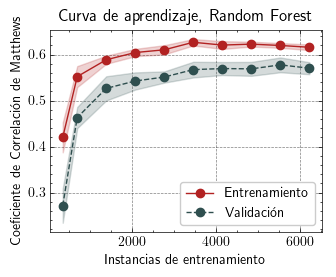

In [24]:
rf = RandomForestClassifier(n_estimators=best_n_estimators,max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
lcu.plot_and_save_learning_curve(rf, 'Random Forest', X_train_encoded, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Predicciones del clasificador Random Forest almacenadas en resultados/predicciones.csv.
Accuracy: 0.8347
Balanced accuracy: 0.6989
Recall: 0.4098
Specificity: 0.9880
AUC: 0.4098
MCC: 0.5453
Precision: 0.9248
F1-score: 0.5679


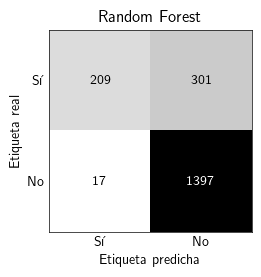

In [25]:
cu.train_and_evaluate_model(rf, X_train_encoded, y_train, X_test_encoded, y_test, 'Random Forest',pos_class,neg_class)

# Gradient Boosting Machine (GBM)

In [26]:
gbm =  GradientBoostingClassifier(criterion='friedman_mse')
n_estimators_range = range(1000,1500,100)
params = {'n_estimators': n_estimators_range}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
best_gbm = GridSearchCV(gbm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', verbose=3)
best_gbm.fit(X_train_scaled, y_train) 
best_mcc = best_gbm.best_score_
best_n_estimators = best_gbm.best_params_['n_estimators']

print(f'Best MCC: {best_mcc}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END n_estimators=1000; balanced_accuracy: (test=0.917) matthews_corrcoef: (test=0.845) total time=  14.1s
[CV 5/10] END n_estimators=1000; balanced_accuracy: (test=0.942) matthews_corrcoef: (test=0.886) total time=  14.2s
[CV 9/10] END n_estimators=1000; balanced_accuracy: (test=0.929) matthews_corrcoef: (test=0.878) total time=  14.2s
[CV 3/10] END n_estimators=1000; balanced_accuracy: (test=0.924) matthews_corrcoef: (test=0.865) total time=  14.2s
[CV 7/10] END n_estimators=1000; balanced_accuracy: (test=0.924) matthews_corrcoef: (test=0.871) total time=  14.2s
[CV 8/10] END n_estimators=1000; balanced_accuracy: (test=0.931) matthews_corrcoef: (test=0.878) total time=  14.2s
[CV 4/10] END n_estimators=1000; balanced_accuracy: (test=0.933) matthews_corrcoef: (test=0.872) total time=  14.2s
[CV 2/10] END n_estimators=1000; balanced_accuracy: (test=0.930) matthews_corrcoef: (test=0.866) total time=  14.2s
[CV 10/10] 

Curvas de aprendizaje del clasificador GBM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


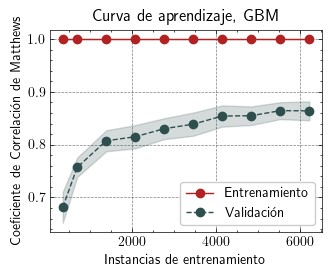

In [27]:
gbm = GradientBoostingClassifier(n_estimators=best_n_estimators, criterion='friedman_mse')
lcu.plot_and_save_learning_curve(gbm, 'GBM', X_train_scaled, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Resultados del clasificador GBM almacenados en resultados/resultados.csv
Predicciones del clasificador GBM almacenadas en resultados/predicciones.csv.
Accuracy: 0.9496
Balanced accuracy: 0.9350
Recall: 0.9039
Specificity: 0.9661
AUC: 0.9039
MCC: 0.8705
Precision: 0.9057
F1-score: 0.9048


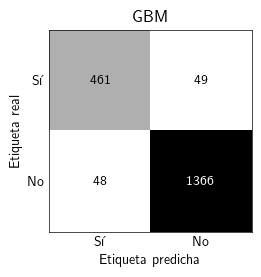

In [28]:
cu.train_and_evaluate_model(gbm, X_train_scaled, y_train, X_test_scaled, y_test, 'GBM', pos_class, neg_class)

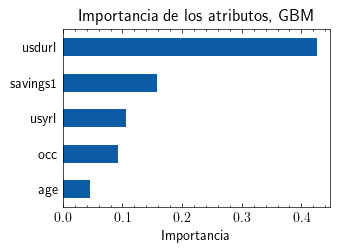

In [29]:
features=X_train_scaled.columns.to_list()
feature_imp = gbm.feature_importances_

df_feature_imp = pd.DataFrame({'importance': feature_imp}, index=features)

with plt.style.context('science'):
    ax = df_feature_imp.sort_values(by='importance', ascending=True).tail().plot.barh()
    ax.set_title('Importancia de los atributos, GBM')
    ax.set_xlabel('Importancia')
    ax.legend().remove()
plt.tight_layout()
ax.tick_params(axis='y', which='both',length=0)
plt.savefig(os.path.join(fu.results_path,'feature_importances_gbm.png'), dpi=300, bbox_inches='tight')
plt.show()

# Multi Layer Perceptron (MLP)

In [30]:
mlp =  MLPClassifier(max_iter=1000, learning_rate='adaptive')
#hidden_layers_range = [(20,5),(20,10),(25,5),(25,10),(30,5),(30,10),(35,5),(35,10),(40,5),(40,10),(45,5),(45,10),
#                       (50,5),(50,10),(55,5),(55,10)] #Número de neuronas en dos capas ocultas del MLP
#hidden_layers_range = [(55,5),(55,10),(60,5),(60,10),(65,5),(65,10),(70,5),(70,10),(75,5),(75,10),(80,5),(80,10),
#                       (85,5),(85,10),(90,5),(90,10),(95,5),(95,10),(100,5),(100,10)] #Número de neuronas en dos capas ocultas del MLP
hidden_layers_range = [(55,25),(55,30),(60,25),(60,30),(65,25),(65,30),(70,25),(70,30),(75,25),(75,30),(80,25),(80,30),
                       (85,25),(85,30),(90,25),(90,30),(95,25),(95,30),(100,25),(100,30)] #Número de neuronas en dos capas ocultas del MLP
alpha_range = np.logspace(-5, 0, 7) #Parámetro de regularización L2
activations = ['logistic', 'tanh', 'relu']
params = {'hidden_layer_sizes': hidden_layers_range, 'alpha': alpha_range, 'activation': activations}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
best_mlp = GridSearchCV(mlp,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef',verbose=3)
best_mlp.fit(X_train_scaled, y_train) 
best_mcc = best_mlp.best_score_
best_alpha = best_mlp.best_params_['alpha']
best_hidden_layers = best_mlp.best_params_['hidden_layer_sizes']
best_activation = best_mlp.best_params_['activation']

print(f'Best MCC: {best_mcc}, best hidden layers: {best_hidden_layers}, best alpha: {best_alpha}, best activation: {best_activation}')

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
[CV 4/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.828) matthews_corrcoef: (test=0.651) total time=  10.0s
[CV 5/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.825) matthews_corrcoef: (test=0.664) total time=  10.3s
[CV 1/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.796) matthews_corrcoef: (test=0.610) total time=  10.4s
[CV 10/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.824) matthews_corrcoef: (test=0.639) total time=  10.4s
[CV 2/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.854) matthews_corrcoef: (test=0.709) total time=  10.6s
[CV 6/10] END activation=logistic, alpha=9.99999999999

Curvas de aprendizaje del clasificador MLP almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


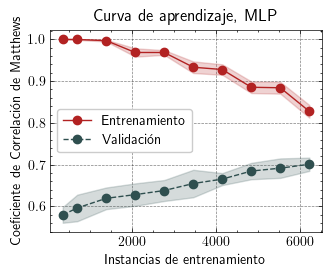

In [31]:
mlp =  MLPClassifier(hidden_layer_sizes=best_hidden_layers,alpha=best_alpha, activation=best_activation, max_iter=2500, learning_rate='adaptive')
lcu.plot_and_save_learning_curve(mlp, 'MLP', X_train_scaled, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Resultados del clasificador MLP almacenados en resultados/resultados.csv
Predicciones del clasificador MLP almacenadas en resultados/predicciones.csv.
Accuracy: 0.8976
Balanced accuracy: 0.8558
Recall: 0.7667
Specificity: 0.9448
AUC: 0.7667
MCC: 0.7314
Precision: 0.8337
F1-score: 0.7988


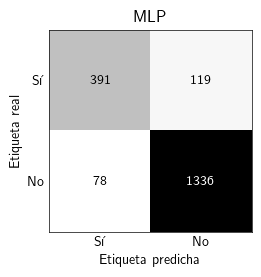

In [32]:
#mlp.out_activation_ = 'logistic'
cu.train_and_evaluate_model(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP', pos_class, neg_class)

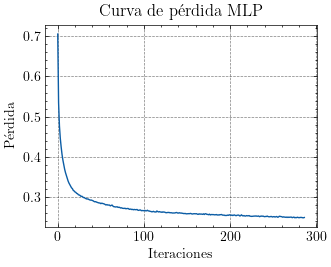

In [33]:
with plt.style.context(['science','grid']):
    fig, ax = plt.subplots()
    ax.plot(mlp.loss_curve_)
    ax.set_title('Curva de pérdida MLP')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Pérdida')
    plt.savefig(os.path.join(fu.results_path,'MLP_loss_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Support Vector Machines (SVMs)

## SVM con kernel lineal

## SVM con kernel RBF Gaussiana

In [34]:
rsvm = SVC(kernel='rbf')
C_range = np.logspace(-3, 0, 7)
gamma_range = np.logspace(-3, 0, 7)
params = {'C': C_range, 'gamma': gamma_range}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
best_rsvm = GridSearchCV(rsvm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', verbose=3)
best_rsvm.fit(X_train_scaled, y_train)
best_mcc = best_rsvm.best_score_
best_C = best_rsvm.best_params_['C']
best_gamma = best_rsvm.best_params_['gamma']
print(f'Best MCC: {best_mcc}, best C: {best_C}, best gamma: {best_gamma}')

Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV 10/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.5s
[CV 4/10] END C=0.001, gamma=0.0031622776601683794; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.5s
[CV 4/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.7s
[CV 3/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.8s
[CV 7/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.8s
[CV 6/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.8s
[CV 9/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.8s
[CV 1/10] END C=0.001, gamma=0.0031622776601683794; balanced_accuracy: (test=0.500) mat

Curvas de aprendizaje del clasificador RBF SVM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


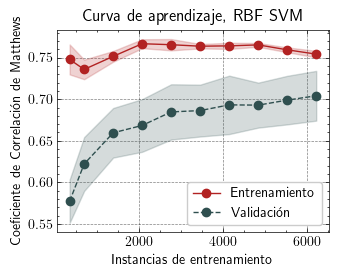

In [35]:
rsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
lcu.plot_and_save_learning_curve(rsvm, 'RBF SVM', X_train_scaled, y_train, scoring='matthews_corrcoef', cv=kf_cv_10, n_jobs=-1)

Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Predicciones del clasificador RBF SVM almacenadas en resultados/predicciones.csv.
Accuracy: 0.8924
Balanced accuracy: 0.8309
Recall: 0.7000
Specificity: 0.9618
AUC: 0.7000
MCC: 0.7127
Precision: 0.8686
F1-score: 0.7752


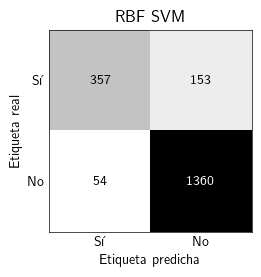

In [36]:
cu.train_and_evaluate_model(rsvm, X_train_scaled, y_train, X_test_scaled, y_test, 'RBF SVM', pos_class, neg_class)

# Regresión Logística

In [37]:
lr = LogisticRegression(max_iter=1000)
C_range = np.logspace(-3, 3, 7)
params = {'C': C_range}
scoring = ['matthews_corrcoef', 'balanced_accuracy']
best_lr = GridSearchCV(lr,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit ='matthews_corrcoef', verbose=3)
best_lr.fit(X_train_scaled, y_train)
best_mcc = best_lr.best_score_
best_C = best_lr.best_params_['C']
print(f'Best MCC: {best_mcc}, best C: {best_C}')

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 3/10] END C=0.001; balanced_accuracy: (test=0.753) matthews_corrcoef: (test=0.598) total time=   0.0s
[CV 8/10] END C=0.001; balanced_accuracy: (test=0.753) matthews_corrcoef: (test=0.597) total time=   0.0s
[CV 2/10] END C=0.001; balanced_accuracy: (test=0.753) matthews_corrcoef: (test=0.614) total time=   0.0s
[CV 6/10] END C=0.001; balanced_accuracy: (test=0.760) matthews_corrcoef: (test=0.617) total time=   0.0s
[CV 1/10] END C=0.001; balanced_accuracy: (test=0.761) matthews_corrcoef: (test=0.626) total time=   0.0s
[CV 10/10] END C=0.001; balanced_accuracy: (test=0.764) matthews_corrcoef: (test=0.599) total time=   0.0s
[CV 7/10] END C=0.001; balanced_accuracy: (test=0.737) matthews_corrcoef: (test=0.582) total time=   0.0s
[CV 5/10] END C=0.001; balanced_accuracy: (test=0.757) matthews_corrcoef: (test=0.631) total time=   0.0s
[CV 9/10] END C=0.001; balanced_accuracy: (test=0.768) matthews_corrcoef: (test=0.646) tot

Curvas de aprendizaje del clasificador Logistic Regression almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


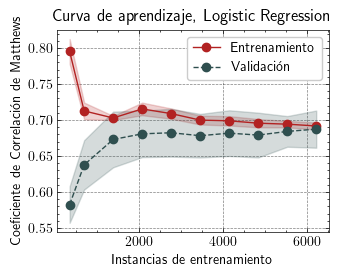

In [38]:
lr = LogisticRegression(C=best_C, max_iter=1000)
lcu.plot_and_save_learning_curve(lr, 'Logistic Regression', X_train_scaled, y_train, scoring='matthews_corrcoef', cv=kf_cv_10)

Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Predicciones del clasificador Logistic Regression almacenadas en resultados/predicciones.csv.
Accuracy: 0.8831
Balanced accuracy: 0.8289
Recall: 0.7137
Specificity: 0.9441
AUC: 0.7137
MCC: 0.6897
Precision: 0.8217
F1-score: 0.7639


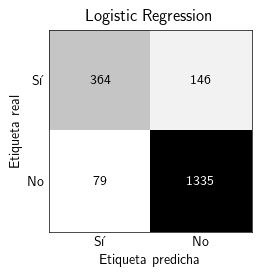

In [39]:
cu.train_and_evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression', pos_class, neg_class)

# Resultados

In [40]:
#predicciones = pd.read_csv(os.path.join(fu.results_path,'predicciones.csv'))
#cmu.plot_save_all_conf_matrices(predicciones,[pos_class[0],neg_class[0]] ,[pos_class[1],neg_class[1]])

In [41]:
resultados = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'resultados.csv')))
resultados.sort_values(by='MCC', ascending=False, inplace=True)
markdown_table = resultados.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)

| Classifier          |   Accuracy |   Balanced_accuracy |   Recall |   Specificity |    AUC |    MCC |   Precision |   F1-score |
|:--------------------|-----------:|--------------------:|---------:|--------------:|-------:|-------:|------------:|-----------:|
| GBM                 |     0.9496 |              0.9350 |   0.9039 |        0.9661 | 0.9350 | 0.8705 |      0.9057 |     0.9048 |
| MLP                 |     0.8976 |              0.8558 |   0.7667 |        0.9448 | 0.8558 | 0.7314 |      0.8337 |     0.7988 |
| RBF SVM             |     0.8924 |              0.8309 |   0.7000 |        0.9618 | 0.8309 | 0.7127 |      0.8686 |     0.7752 |
| Logistic Regression |     0.8831 |              0.8289 |   0.7137 |        0.9441 | 0.8289 | 0.6897 |      0.8217 |     0.7639 |
| Decision Tree       |     0.8680 |              0.8199 |   0.7176 |        0.9222 | 0.8199 | 0.6545 |      0.7689 |     0.7424 |
| 15-NN               |     0.8638 |              0.7833 |   0.6118 |        0.9547

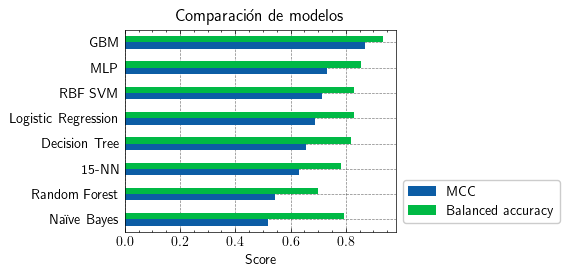

In [42]:
cu.plot_scores(resultados,['MCC','Balanced_accuracy'], ['MCC','Balanced accuracy'], 'MCC', 'Comparación de modelos')

Learning curves de validación de todos los clasificadores

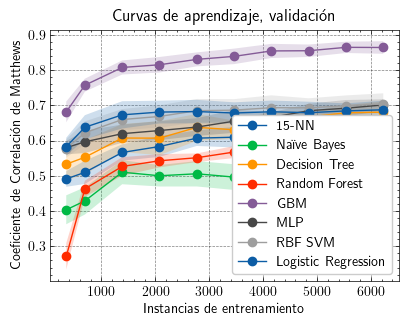

In [43]:
lcu.plot_and_save_all_learning_curves()